# In this notebook the purpose was to solve the task with the manually calculated 1. Variation of out given functional

In [1]:
from netgen.meshing import *
from ngsolve import *
from netgen.meshing import Mesh as NGMesh
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry, unit_square
import matplotlib.pyplot as plt
import numpy as np
import pickle
from ngsolve import CoefficientFunction
from ngsolve.meshes import MakeStructured2DMesh
import time

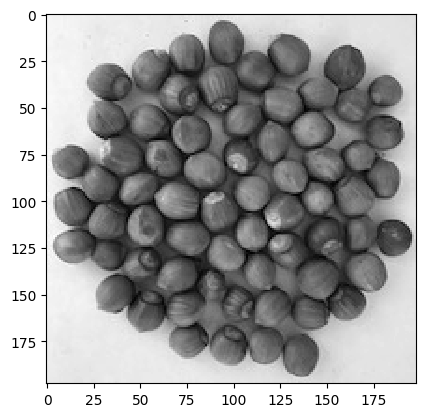

In [2]:
with open('img.pkl','rb') as fp:
    img = pickle.load(fp)
plt.imshow(img,interpolation='none', cmap='gray')

In [3]:
mesh = MakeStructured2DMesh(nx=int((img.shape[0]-1)/1),
                            ny=int((img.shape[1]-1)/1),
                            quads=False)
cfImg = VoxelCoefficient((0,0),(1,1),
                         img[np.arange(img.shape[0]-1,-1,-1)])
Draw(cfImg,mesh,'cfImg')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [4]:
# Gegeben aus Aufgabenstellung:
eps = 1e-6
# wir haben festgestellt, dass wenn wir 0.1 verkleinern divergiert es weniger schnell aaaaber es divergiert immer noch!
dt = 0.1
t0 = 0
tend = 2
t = t0

In [5]:
# FEM Raum => Annahme Order = 2
V = H1(mesh, order=2)

# Trial Funktion
u = V.TrialFunction()
# u_n = V.TrialFunction() 
# Test Funktion
v = V.TestFunction()

# w = V.TrialFunction()

gfu = GridFunction(V)
gfuold = GridFunction(V)

Das Bild ist nicht normalisiert, es enthält Werte zwischen -1 und 1, das ist ideal für unsere Anwendung. Wir werden deshalb nichts normalisieren müssen.

In [6]:
# 1. Variation ist gegeben durch: 
# Achtung: diskretisiert! => enthählt daher u_n
# (((2*u*v)*(1-u**2)**2)+(u**2*2*(1-u**2)*2*u*v)+(1/dt*(u-u_n)*v))*dx

In [7]:
a = BilinearForm(V, symmetric = False)
a += (((2*u*v)*(1-u**2)**2)+(u**2*2*(1-u**2)*2*u*v)+(1/dt*(u-gfuold)*v))*dx
'''
a = BilinearForm (V, symmetric = False)
a += Variation((eps/2*grad(u)*grad(u) 
               +(u**2*(1-u*u)**2)
               + 0.5/dt*(u-gfu)**2)*dx)
'''

'\na = BilinearForm (V, symmetric = False)\na += Variation((eps/2*grad(u)*grad(u) \n               +(u**2*(1-u*u)**2)\n               + 0.5/dt*(u-gfu)**2)*dx)\n'

In [8]:
# 2. Variation ist gegeben durch: 
# (grad(u)*grad(v)+((2*v*w)*(1-5*u**2)*(1-u)**2)-((4*v*w*u**2)*(5*u**2-3))+1/dt*w*v)*dx

In [9]:
a1 = BilinearForm(V, symmetric = False)
a1 += (grad(gfu)*grad(v)+((2*v*u)*(1-5*gfu**2)*(1-gfu)**2)-((4*v*u*gfu**2)*(5*gfu**2-3))+1/dt*u*v)*dx
# a.AssembleLinearization(gfu.vec)

In [10]:
gfu.Set(cfImg)

In [11]:
res = gfu.vec.CreateVector()
du = gfu.vec.CreateVector()

In [12]:
start_time = time.time()
for it in range(int((tend-t0)/dt)):
    print("Newton iteration", it)    
    # solve linearized problem:
    # F(u_n)
    a.Apply(gfu.vec, res)

    # F'(u_n)   
    # a.AssembleLinearization(gfu.vec)
    a1.Assemble()

    # F'(u_n) du = F(u_n)
    # du.data = a.mat.Inverse(V.FreeDofs()) * res
    du.data = a1.mat.Inverse(V.FreeDofs()) * res

    gfuold.vec.data = gfu.vec
    # update iteration
    # u_n+1 = u_n - du
    gfu.vec.data -= du

    # Abbruchkriterium: nach 2 Sekunden (wie in Aufgabenstellung beschrieben)
    t += dt
    print(t)
    if t >= tend:
        break

    # stopping criteria
    stopcritval = sqrt(abs(InnerProduct(du, res)))
    print("<A u", it, ", A u", it, ">_{-1}A0.S = ", stopcritval)
    print(gfu)
    if stopcritval < 1e-13:
        break
end_time = time.time()
time_to_compute = end_time - start_time

Newton iteration 0
0.1
<A u 0 , A u 0 >_{-1}A0.S =  2.8859584482514484
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 1
0.2
<A u 1 , A u 1 >_{-1}A0.S =  1011709560378.0408
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 2
0.30000000000000004
<A u 2 , A u 2 >_{-1}A0.S =  822556956493.9413
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 3
0.4
<A u 3 , A u 3 >_{-1}A0.S =  668768904118.1176
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 4
0.5
<A u 4 , A u 4 >_{-1}A0.S =  543733568931.9032
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 5
0.6
<A u 5 , A u 5 >_{-1}A0.S =  442075251648.3038
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 6
0.7
<A u 6 , A u 6 >_{-1}A0.S =  359671800814.4353


In [13]:
print(f"Gebrauchte Zeit, um das Newton Verfahren zu machen: {round(time_to_compute, 3)} Sekunden!")

Gebrauchte Zeit, um das Newton Verfahren zu machen: 27.034 Sekunden!


In [14]:
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

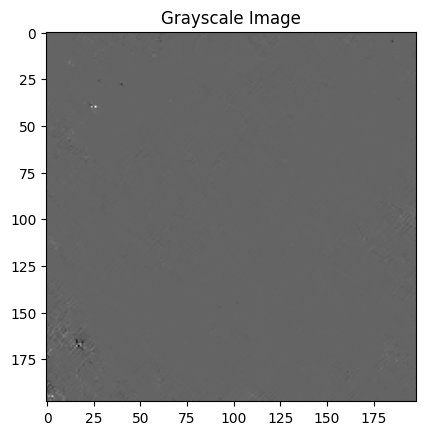

In [15]:
imgNew = np.array([[gfu(mesh(i/(img.shape[0]-1), 1-j/(img.shape[1]-1)))
                for i in range(img.shape[0])]
                for j in range(img.shape[0])]) 
plt.imshow(imgNew, cmap='gray')
plt.title('Grayscale Image')
plt.show()

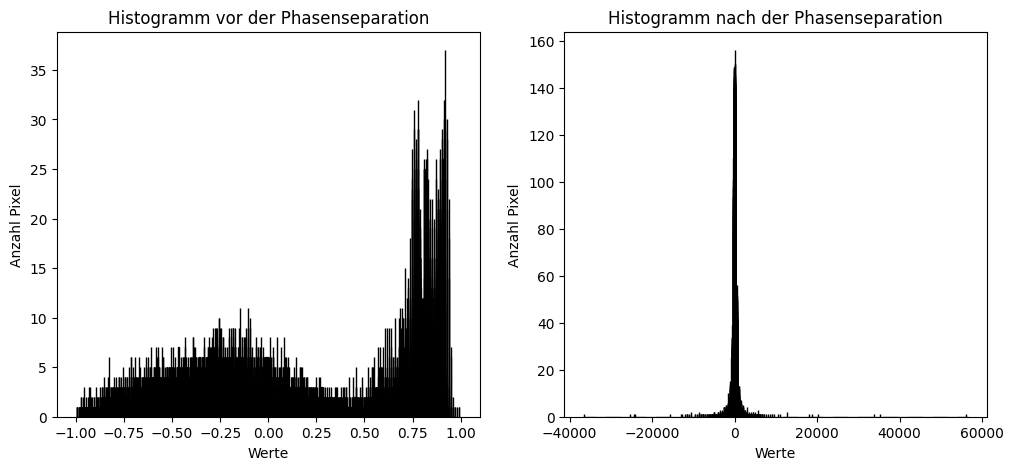

In [16]:
# Anzahl bins
num_bins = 200

# subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot des ersten Histogramms => vor der Phasenseparation
axs[0].hist(img, bins=num_bins, edgecolor='black')
#axs[0].set_yscale('log')  # y-Achse logarithmisch => Phasenseparation besser ersichlich in linearer y-Achse
axs[0].set_title('Histogramm vor der Phasenseparation')
axs[0].set_xlabel('Werte')
axs[0].set_ylabel('Anzahl Pixel')

# Plot des zweiten Histogramms => nach der Phasenseparation
axs[1].hist(imgNew, bins=num_bins, edgecolor='black')
#axs[1].set_yscale('log')  # y-axis logarithmisch
axs[1].set_title('Histogramm nach der Phasenseparation')
axs[1].set_xlabel('Werte')
axs[1].set_ylabel('Anzahl Pixel')

plt.show()